In [176]:
subj = "Subj1"
exp = "exp_final"

n_stages = [ 9, 8, 10 ][int(subj[-1:]) - 1]
scale = False

### Imports

In [177]:
%load_ext autoreload
%autoreload 2

import os

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import tqdm
import numpy
import pandas
import matplotlib.pyplot as plt

pandas.set_option("display.precision", 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [178]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")

df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
df_all_features = pandas.read_feather(f"{subj}/{exp}/all_features.feather")

features = df_features.to_numpy()
print('Features: ', features.shape)
print('All features: ', df_all_features.shape)

Opening raw data file Subj1/src/data_rr_filt-raw.fif...
    Range : 3500 ... 471000 =      7.000 ...   942.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
Features:  (1046, 65)
All features:  (1046, 19563)


In [179]:
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]
    features = features[:-2]
    df_all_features = df_all_features[:-2]

### SDA

In [180]:
result, df_st_edges = SDA.SDA(scale = scale).apply(features)

Applying to 1046 samples with 65 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [181]:
edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
print(edges_true)

metrics = [ ]
for row in tqdm.tqdm(result['St_edges']):
    metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
result = pandas.concat([ result, pandas.DataFrame(metrics) ], axis = 1)

[   0   39  282  492  560  682  784  857  976 1046]


100%|██████████| 2016/2016 [00:06<00:00, 322.05it/s]


In [182]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

In [183]:
def analyze(result: pandas.DataFrame, key: str, folder: str):
    if not os.path.exists(f"{subj}/{exp}/{folder}"):
        os.makedirs(f"{subj}/{exp}/{folder}")

    results = SDA.analytics.best_results(result, key = key)
    results.to_csv(f"{subj}/{exp}/{folder}/results.csv")
    display(results)
    
    best_result = SDA.analytics.best_result(result, key = key, n_stages = n_stages)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{subj}/{exp}/{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{subj}/{exp}/{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
    edge_statistics.to_csv(f"{subj}/{exp}/{folder}/edge_statistics.csv")
    display(edge_statistics)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{subj}/{exp}/{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_stats(features, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/stats.svg")
    SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/{folder}/features.svg")
    SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/eeg_stages.svg")

    return best_edges

#### Internal

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,50,20,3,Mode,"[0, 486, 682, 1046]",319277.53,48.01,2.21e-02,31.93,5.68,0.06,40.17,3.69,0.65,0.43,0.61
1,0,35,20,4,Median,"[0, 210, 558, 932, 1046]",144123.49,30.06,1.34e-02,22.65,7.90,0.04,19.26,6.87,0.64,0.42,0.57
2,60,40,15,5,Median,"[0, 210, 554, 682, 842, 1046]",302956.98,56.67,1.58e-02,31.60,5.49,0.09,39.98,3.14,0.75,0.57,0.67
3,20,40,20,6,Mode,"[0, 124, 210, 554, 682, 842, 1046]",234344.92,53.79,5.38e-03,28.19,5.25,0.08,31.08,3.25,0.73,0.53,0.62
4,20,40,20,7,Mode,"[0, 124, 210, 554, 682, 842, 976, 1046]",237507.41,57.39,7.91e-03,27.41,5.66,0.09,31.25,3.00,0.77,0.57,0.65
5,60,35,20,8,Median,"[0, 124, 210, 337, 554, 682, 842, 976, 1046]",189483.70,51.20,4.95e-03,24.68,5.79,0.08,24.97,3.61,0.78,0.59,0.64
6,0,40,20,9,Mode,"[0, 52, 252, 280, 554, 682, 801, 842, 976, 1046]",149649.50,52.64,-1.28e-02,21.65,5.54,0.07,19.67,3.35,0.87,0.79,0.82
7,60,35,20,10,Median,"[0, 124, 210, 337, 486, 554, 682, 780, 842, 97...",122653.90,48.45,6.22e-05,21.65,5.38,0.06,16.38,3.70,0.83,0.66,0.71
8,40,35,20,11,Median,"[0, 81, 124, 210, 335, 486, 554, 682, 784, 842...",105971.03,45.48,-1.23e-02,19.77,5.58,0.06,14.03,3.97,0.83,0.66,0.71
9,60,35,20,12,Mean,"[0, 81, 127, 203, 262, 335, 484, 551, 680, 779...",93308.88,43.91,-1.75e-02,17.80,5.54,0.06,12.34,4.03,0.81,0.64,0.70


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,40,20,9,Mode,"[0, 52, 252, 280, 554, 682, 801, 842, 976, 1046]",149649.5,52.64,-0.01,21.65,5.54,0.07,19.67,3.35,0.87,0.79,0.82


array([   0,   52,  252,  280,  554,  682,  801,  842,  976, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.02,11.91,3.35,75778.75,42.85
1,0.06,4.95,4.28,34437.68,37.44
2,0.03,3.58,5.10,26501.09,32.30
3,0.11,48.57,2.60,364471.85,64.63
4,0.13,43.34,2.30,333756.50,73.57
5,0.04,7.76,3.75,56335.70,42.98
6,0.09,19.16,2.38,150327.45,69.20
7,0.08,18.11,3.03,155586.99,58.17


,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 55.5)","(56.3, 236.3)","(237.1, 261.9)","(262.7, 506.7)","(507.5, 620.3)","(621.1, 723.5)","(724.3, 758.7)","(759.5, 877.1)","(877.9, 938.7)"
"Time length, sec",45.6,180.0,24.8,244.0,112.8,102.4,34.4,117.6,60.8
Number of epochs,52,200,28,274,128,119,41,134,70


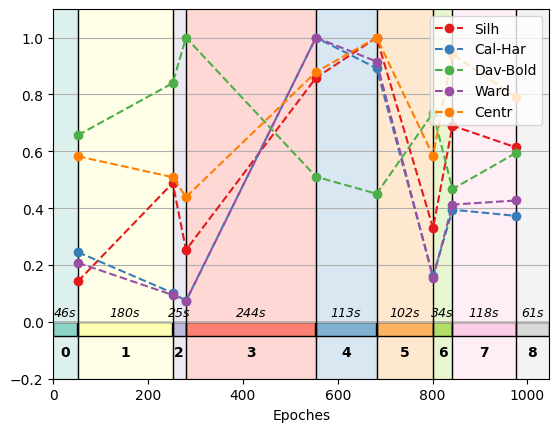

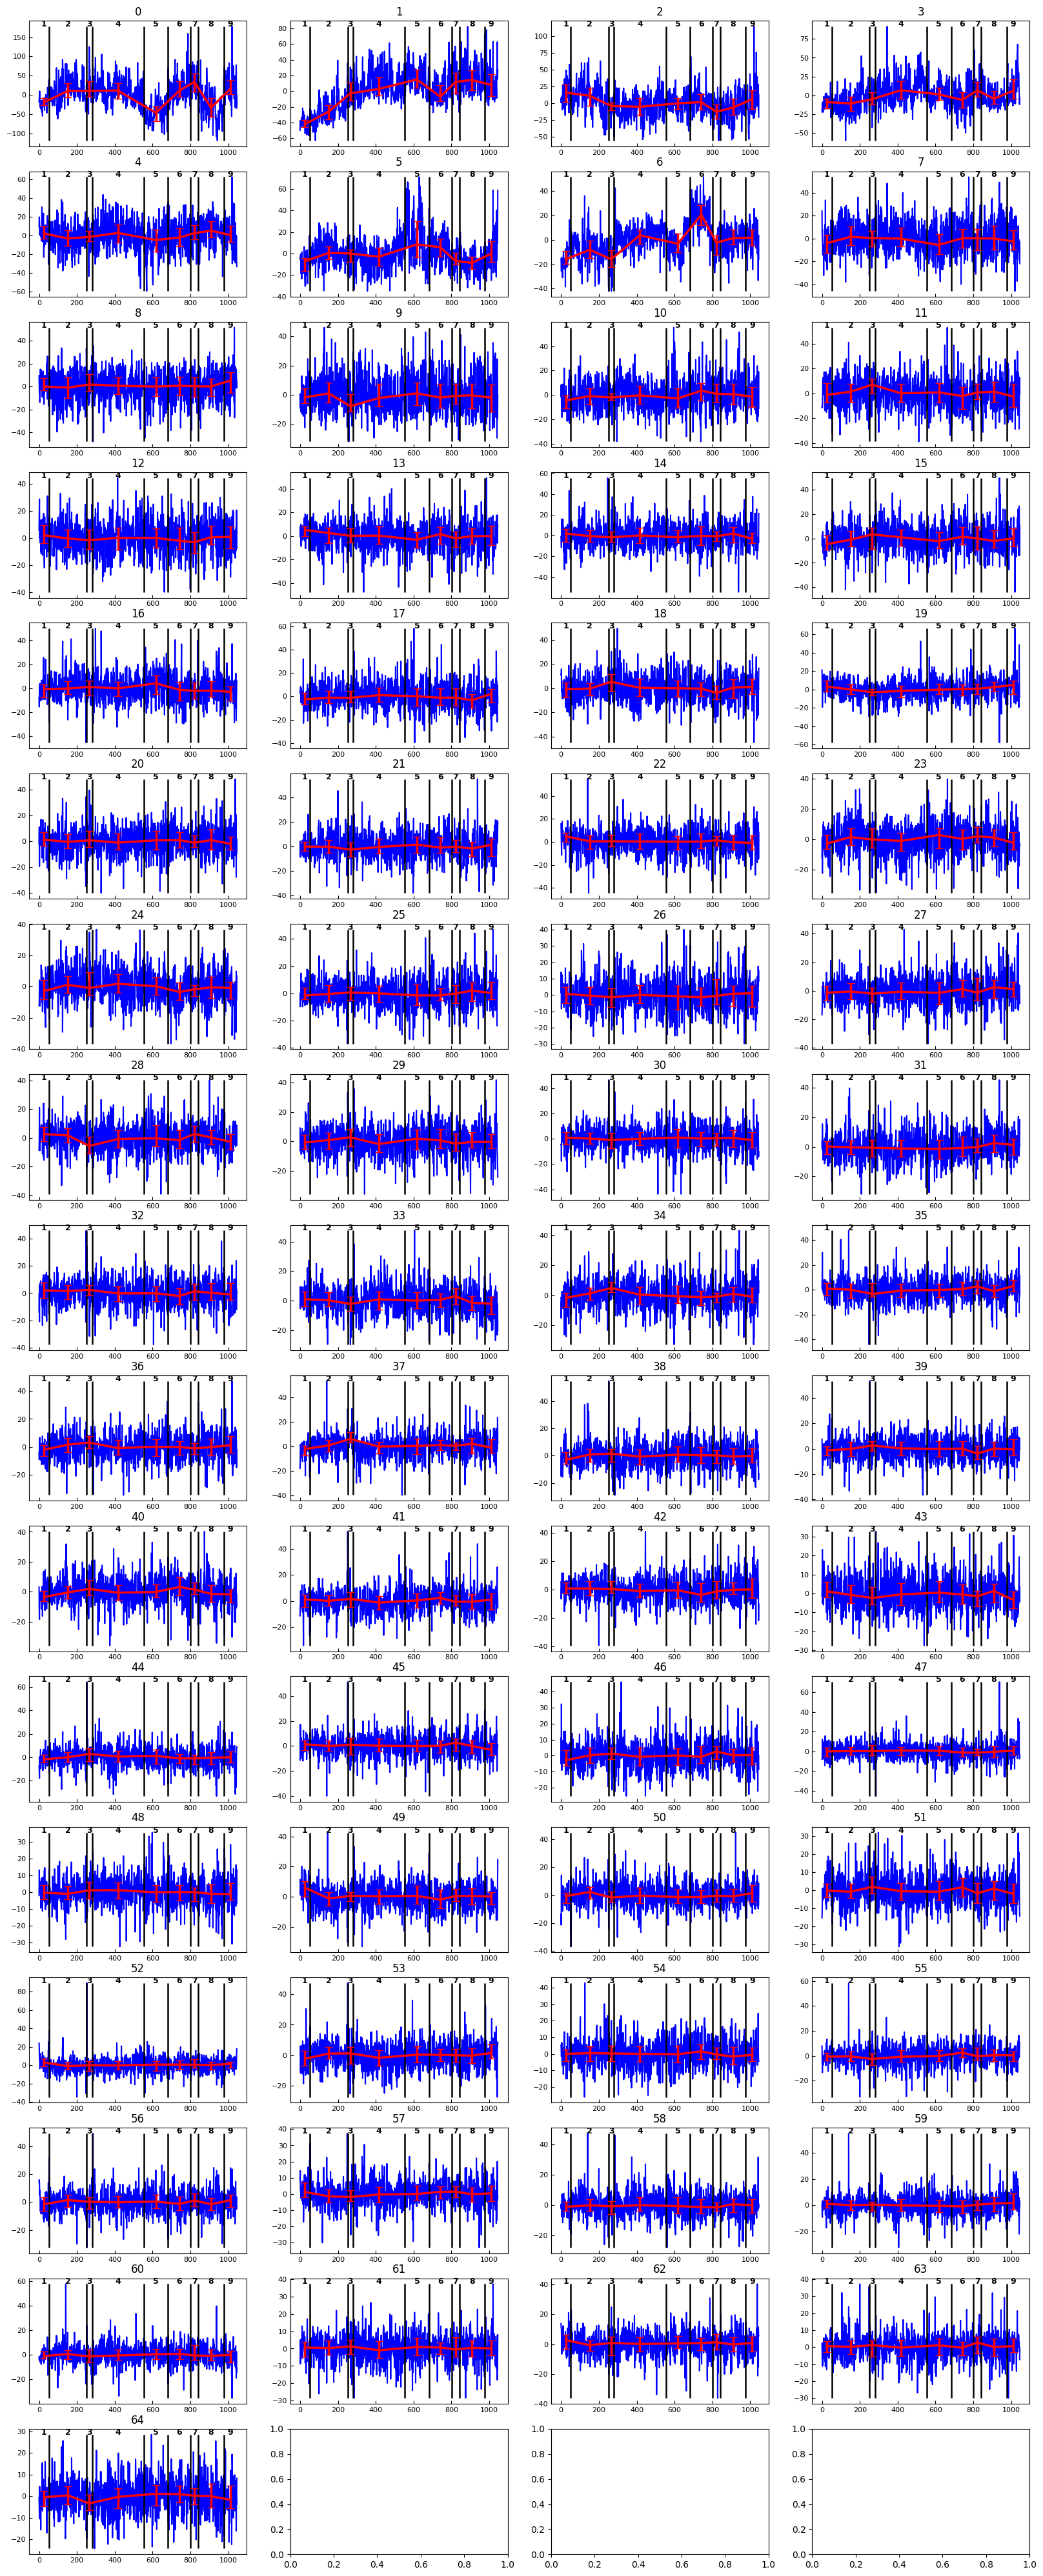

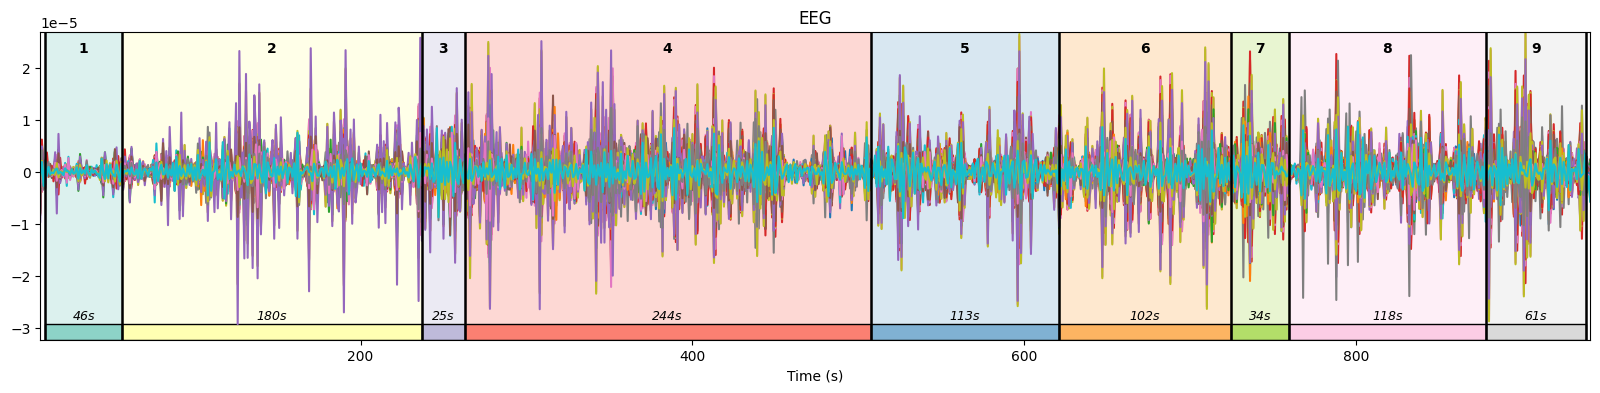

In [184]:
internal_edges = analyze(result, 'Avg-Silh', "internal")

#### External

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,50,20,3,Mode,"[0, 486, 682, 1046]",319277.53,48.01,2.21e-02,31.93,5.68,0.06,40.17,3.69,0.65,0.43,0.61
1,40,50,15,4,Mode,"[0, 342, 554, 842, 1046]",108122.90,28.08,5.82e-03,20.62,7.35,0.02,14.07,6.73,0.69,0.53,0.65
2,60,50,10,5,Mode,"[0, 342, 554, 682, 842, 1046]",262357.45,54.15,1.16e-02,29.00,5.62,0.08,34.41,3.34,0.76,0.62,0.70
3,40,50,10,6,Mean,"[0, 88, 267, 533, 682, 875, 1046]",202609.88,46.60,-8.74e-03,25.23,6.06,0.06,26.51,3.78,0.78,0.66,0.72
4,0,40,20,7,Mode,"[0, 52, 252, 554, 682, 842, 976, 1046]",243772.69,56.78,-2.60e-03,26.76,5.83,0.08,31.94,3.01,0.84,0.73,0.78
5,0,40,20,8,Mode,"[0, 52, 252, 280, 554, 682, 842, 976, 1046]",187372.19,52.80,-3.11e-03,23.50,5.75,0.07,24.48,3.36,0.86,0.77,0.81
6,0,40,15,9,Mode,"[0, 52, 210, 280, 486, 554, 682, 842, 976, 1046]",145861.22,48.35,-1.33e-02,22.32,5.53,0.06,19.16,3.59,0.88,0.79,0.82
7,0,40,15,10,Mode,"[0, 52, 210, 280, 486, 554, 682, 842, 976, 102...",124671.33,46.52,-1.48e-02,20.26,5.85,0.05,16.52,3.74,0.87,0.78,0.82
8,0,40,20,11,Mode,"[0, 52, 252, 280, 486, 554, 682, 801, 842, 976...",96042.49,47.32,-1.60e-02,18.76,5.73,0.05,12.78,3.69,0.89,0.85,0.88
9,0,40,10,12,Mode,"[0, 52, 124, 210, 280, 486, 554, 681, 801, 842...",91220.37,44.93,-2.08e-02,18.08,5.74,0.05,12.21,3.85,0.85,0.75,0.79


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,40,15,9,Mode,"[0, 52, 210, 280, 486, 554, 682, 842, 976, 1046]",145861.22,48.35,-0.01,22.32,5.53,0.06,19.16,3.59,0.88,0.79,0.82


array([   0,   52,  210,  280,  486,  554,  682,  842,  976, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.02,11.64,3.31,74503.75,43.64
1,0.03,8.27,4.50,56807.74,34.22
2,0.02,7.19,5.02,51071.75,31.27
3,0.03,9.56,4.40,68004.40,36.47
4,0.05,14.25,3.35,106086.17,48.88
5,0.13,51.59,2.27,397184.31,74.74
6,0.09,32.68,2.88,257644.67,59.44
7,0.08,18.11,3.03,155586.99,58.17


,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 55.5)","(56.3, 198.7)","(199.5, 261.9)","(262.7, 449.9)","(450.7, 506.7)","(507.5, 620.3)","(621.1, 758.7)","(759.5, 877.1)","(877.9, 938.7)"
"Time length, sec",45.6,142.4,62.4,187.2,56.0,112.8,137.6,117.6,60.8
Number of epochs,52,158,70,206,68,128,160,134,70


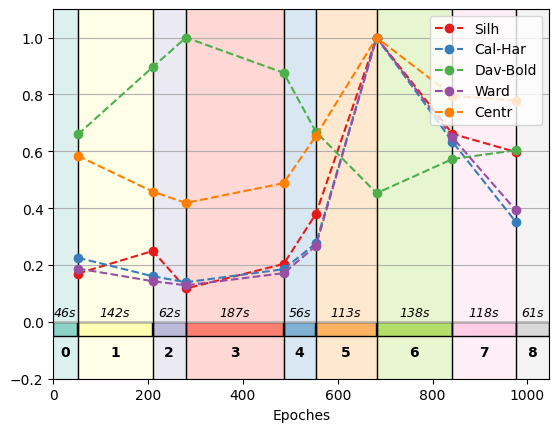

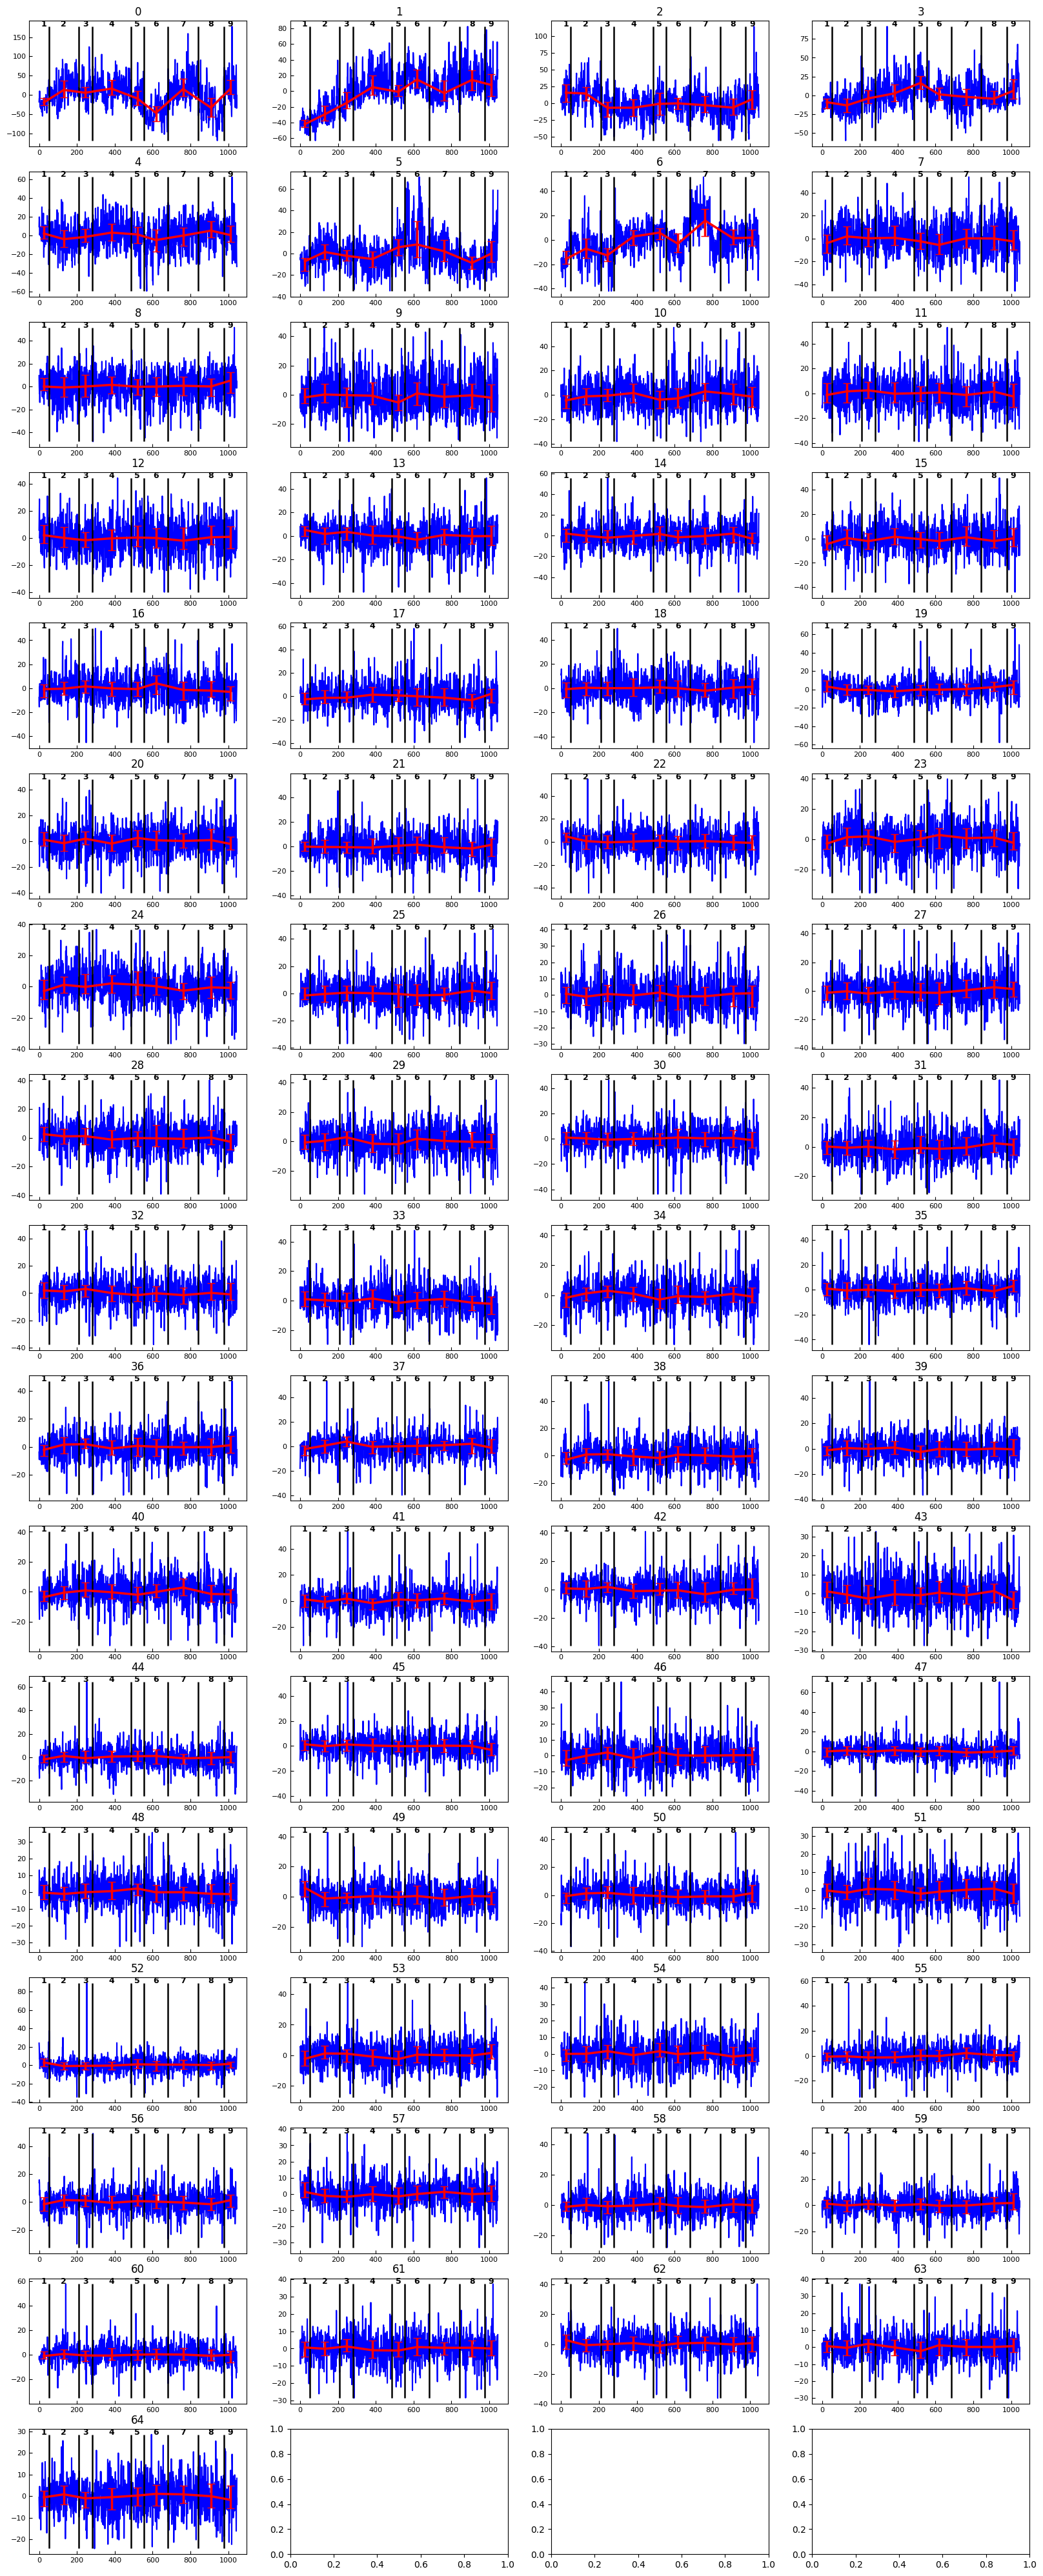

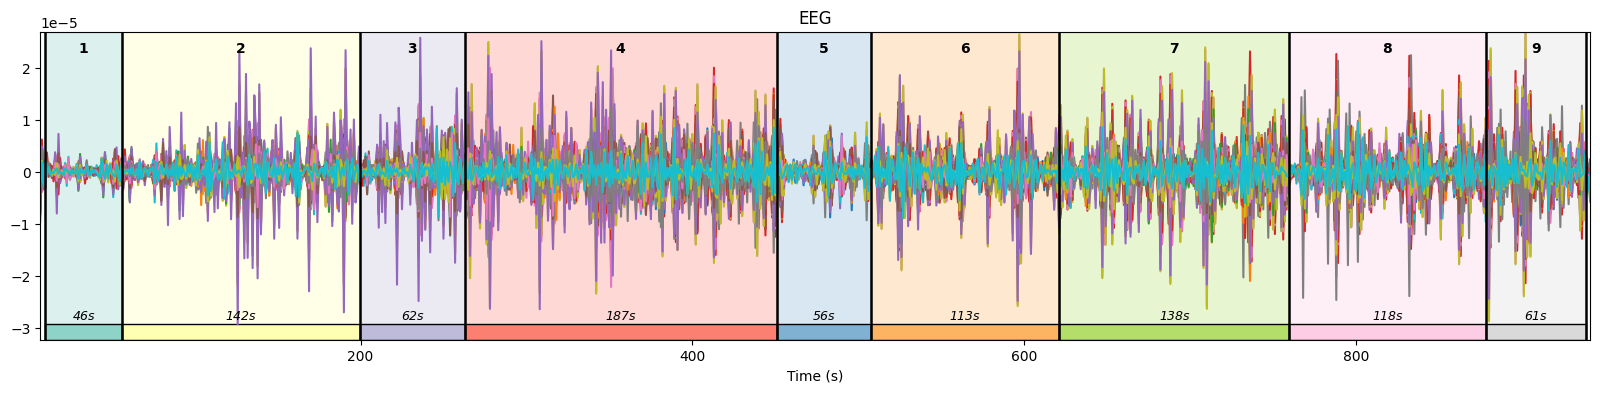

In [185]:
external_edges = analyze(result, 'FMI', "external")

### IV

In [186]:
IV = pandas.DataFrame(df_all_features.columns, columns = [ "Feature" ])
for edges, name, path in zip(
    [ edges_true, internal_edges, external_edges ],
    [ "true", "internal", "external" ],
    [ "true_iv", "internal/iv", "external/iv" ]
):
    _, labels = SDA.stageprocess.form_stage_bands(edges)
    edges_iv = SDA.analytics.IV.calc_IV_clust(df_all_features, labels)
    edges_iv.to_csv(f"{subj}/{exp}/{path}.csv")
    IV[name] = edges_iv["IV"]
IV

100%|██████████| 19563/19563 [09:19<00:00, 34.99it/s]


,Feature,true,internal,external
0,channel-0 betti dim-1 max,0.34,0.34,0.33
1,channel-0 betti dim-1 mean,0.00,0.00,0.00
2,channel-0 betti dim-1 std,0.44,0.45,0.40
3,channel-0 betti dim-1 sum,0.00,0.00,0.00
4,channel-0 betti dim-1 percentile-25,0.00,0.00,0.00
...,...,...,...,...
19558,overall bd2 dim-3 percentile-75,0.70,0.68,0.62
19559,overall bd2 dim-3 kurtosis,0.15,0.15,0.13
19560,overall bd2 dim-3 skew,0.19,0.19,0.18
19561,overall bd2 dim-3 norm-1,0.44,0.44,0.40


In [187]:
IV["internal-diff"] = IV["true"] - IV["internal"]
IV["external-diff"] = IV["true"] - IV["external"]
IV.to_csv(f"{subj}/{exp}/IV.csv")
IV

,Feature,true,internal,external,internal-diff,external-diff
0,channel-0 betti dim-1 max,0.34,0.34,0.33,1.92e-03,0.01
1,channel-0 betti dim-1 mean,0.00,0.00,0.00,0.00e+00,0.00
2,channel-0 betti dim-1 std,0.44,0.45,0.40,-3.51e-03,0.05
3,channel-0 betti dim-1 sum,0.00,0.00,0.00,0.00e+00,0.00
4,channel-0 betti dim-1 percentile-25,0.00,0.00,0.00,0.00e+00,0.00
...,...,...,...,...,...,...
19558,overall bd2 dim-3 percentile-75,0.70,0.68,0.62,2.77e-02,0.08
19559,overall bd2 dim-3 kurtosis,0.15,0.15,0.13,2.26e-03,0.02
19560,overall bd2 dim-3 skew,0.19,0.19,0.18,-3.82e-04,0.01
19561,overall bd2 dim-3 norm-1,0.44,0.44,0.40,-3.16e-03,0.04


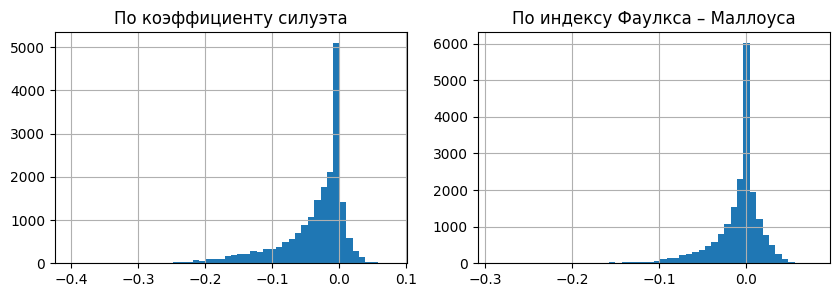

In [218]:
fig, axes = plt.subplots(1, 2, figsize = (10, 3))

axes[0].set_title('По коэффициенту силуэта')
IV["internal-diff"].hist(ax = axes[0], bins = 50)

axes[1].set_title('По индексу Фаулкса – Маллоуса')
IV["external-diff"].hist(ax = axes[1], bins = 50)

plt.savefig(f"{subj}/{exp}/IV-diffs.svg")
plt.savefig(f"{subj}/{exp}/IV-diffs.png")